### Problem 4-24
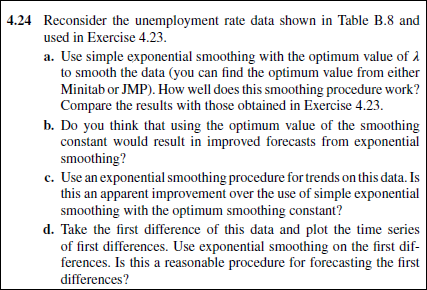

The data is the same unemployment data used in problem 3-23.  Refer there for more information.

### Import Excel data.

The original table B-8 had multiple date/rate pairs spread across rows,making it very difficult to import and process directly.  The table was reformmated so there are only two columns:

| Field | Description |
|:-|:-|
| Date  | Sample date in mm/dd/yyyy format |
| Rate  | Unemployment rate in percent     |

In [2]:
proc import out=Unemployment 
  datafile='Table B-8 MMDDYYYY Format.xlsx' 
  dbms=xlsx replace; 
  getnames=yes; datarow=2;
 run;

### Part (a) Find Optimal value of $\lambda$
PROC ESM does not allow specification of a level (Y-value) weight.  Instead, it calculates the optimal value of $\lambda$ by minimizing MSE as well as accounting for the length of the time periods.  The actual ESM optimization algorithm is fairly opaque at this time - a research project has been started to learn more, but for now the value calculated by ESM will be assumed as valid.

Experimentation has shown that ESM tends to favor larger $\lambda$ values.  For our data, this behavior is no exception, as the optimal $\lambda$ is calculated to be 0.999.

In [19]:
proc esm data=Unemployment print=estimates out=UnemploymentForecast outest=est outstat=stat;
  id Date interval=month;
  forecast rate / model=simple;
run;

### Part(a) How Well Does "Optimal" Smoothing Work?

The calculated value of $\lambda$ will be fed into PROC FORECAST so a direct comparison can be done with the forecast in problem 4-23.

In [20]:
title "Forecast with Exponential Smoothing (Optimal Lambda)";
proc forecast data=Unemployment
              method=expo
              weight=0.999
              interval=MONTH
              out=UnemploymentForecast outfull outresid outest=est;
  id Date;
  var Rate;
run;

### Original Time-Series Curve
Provided for reference


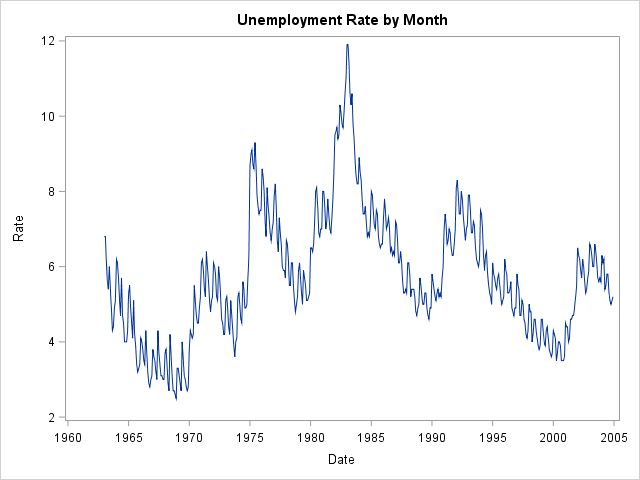

In [21]:
ods graphics on;
title "Unemployment Rate by Month";
proc sgplot data=Unemployment;
  series x=Date y=Rate;
  format date YEAR4.;
run;

### Forecast Results - Smoothing
Using the output data set *UnemploymentForecast*, produce a time-series plot of the smoothed data, adding a vertical reference line to demarcate the last 2 years of data.

The smoothing results are non-existent and really only very recent data has any type of smoothing.  There does appear to be a minor change to the older data, in that it is a bit more concentrated around the large cycles.


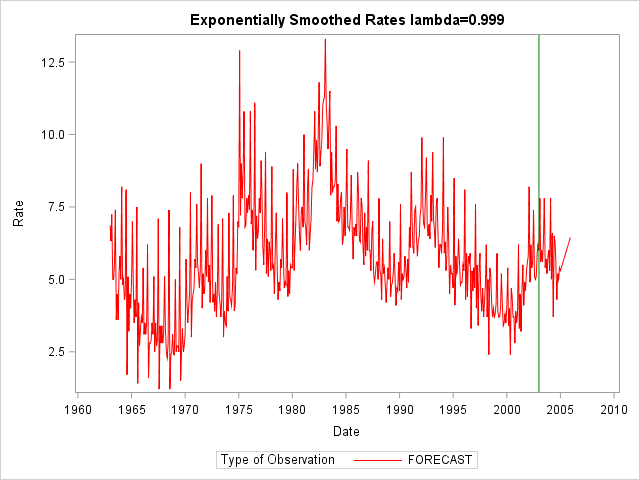

In [22]:
title "Exponentially Smoothed Rates lambda=0.999";
proc sgplot data=UnemploymentForecast;
  series x=Date y=Rate / group =_type_ lineattrs=(color=red);
  where _type_ = 'FORECAST';
  refline '1jan03'd / axis=x lineattrs=(color=green);
  format date YEAR4.;
run;

### Part(b) Is New Smoothing Better?
As with problem 4-23, the last 2 years of data plus the predicted data for the next year are plotted.

The results are *terrible*.  Because there is virtuall no smoothing for the older data, the predicted and actual values are essentially the same.  WHy do the predicted and actual values appear to be zero, and why is the Y-axis scale now so large (10000%)?  It's because the prediction CI values are enormous, which can be seen in the next step.


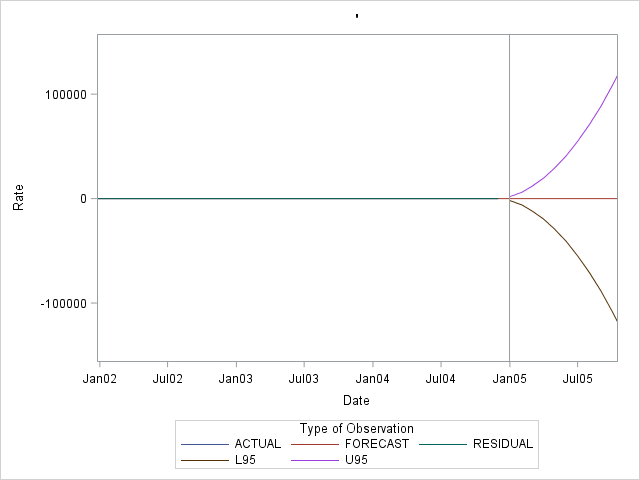

In [23]:
title "";
proc sgplot data=UnemploymentForecast;
  series x=Date y=Rate / group=_type_;
  xaxis values=('1jan02'd to '31dec05'd by qtr);
  refline '31dec04'd / axis=x;
  format date monyy5.;
run;

### CI Details

The first lead period has a prediction CI of -1958% to 1658%.  Things go rapidly downhill from there,
with the 12th lead period having a prediction CI of about +/- 15,000%.

There is no confidence in these predictions.

In [24]:
proc print data=UnemploymentForecast;
  var _LEAD_ _TYPE_ Rate;
  where Date >= '1Jan05'd and _TYPE_ ^= 'FORECAST';
run;

Obs,_LEAD_,_TYPE_,Rate
1514,1,L95,-1958.389311
1515,1,U95,1968.9905097
1517,2,L95,-5880.101852
1518,2,U95,5890.9054468
1520,3,L95,-11760.43494
1521,3,U95,11771.442128
1523,4,L95,-19599.48564
1524,4,U95,19610.697619
1526,5,L95,-29397.28648
1527,5,U95,29408.704454


### Part(c) - Exponential Smoothing of Trends
PROC FORECAST can be used to do a linear trend.  Since the so-called optimal $\lambda$ is not optimal
at all, return to using $\lambda$ = 0.2, which produced a reasonable forecast for problem 3-23.

In [29]:
title "Forecast with Exponential Smoothing On Linear Trend";
proc forecast data=Unemployment
              method=expo
              trend=2
              weight=0.2
              interval=MONTH
              out=UnemploymentForecast outfull outresid outest=est;
  id Date;
  var Rate;
run;

### The smoothed trend time series
For reference, here's the exponentially smoothed trend from problem 4-23:
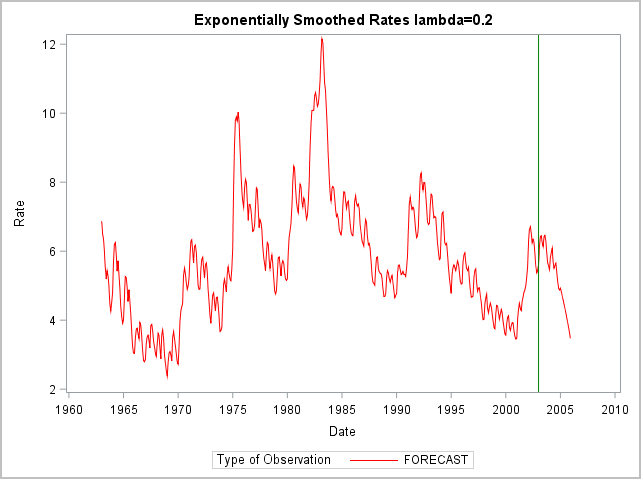

The linear trend exponential smoothing clearly has more of a smoothing impact than just simple exponential smoothing.


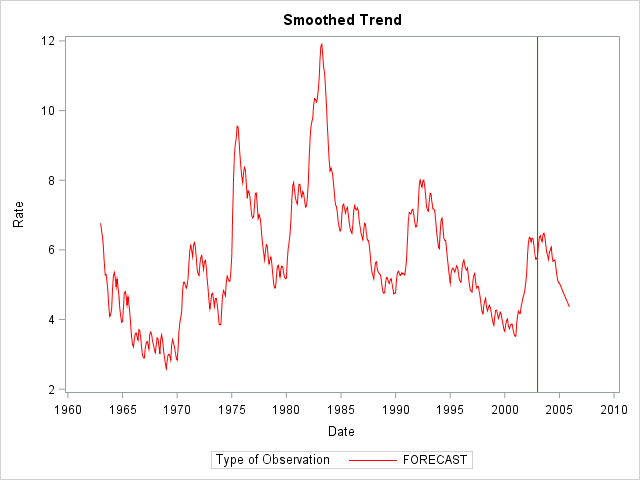

In [32]:
title "Smoothed Trend";
proc sgplot data=UnemploymentForecast;
  series x=Date y=Rate / group =_type_ lineattrs=(color=red);
  where _type_ = 'FORECAST';
  refline '1jan03'd / axis=x lineattrs=(color=green);
  format date YEAR4.;
run;

### Smoothed Trend CI
For reference, here is the CI plot from problem 4-23:
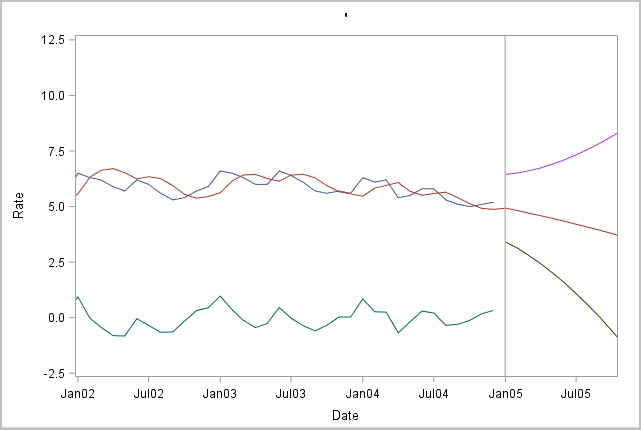
The results of the linear trend smoothing are clearly superior.  The prediction confidence
interval is now almost constant, indicating that this model is predicting values with the same confidence in lead period 1 as it does in lead period 12.  A very nice improvement!


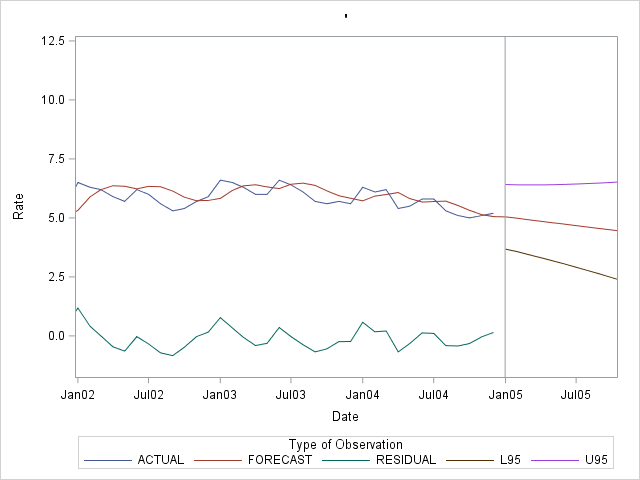

In [31]:
title "";
proc sgplot data=UnemploymentForecast;
  series x=Date y=Rate / group=_type_;
  xaxis values=('1jan02'd to '31dec05'd by qtr);
  refline '31dec04'd / axis=x;
  format date monyy5.;
run;

### Part (d) - First Difference Exploration
Take the first difference of the unemployment rate.

In [35]:
data DiffUnemployment;
  set Unemployment;
  DiffRate = Dif1(Rate);
run;

### Differenced Rate Time Series
Plot the differenced rate by month.  Now we are not dealing with a strict unemployment
rate, but rather the difference between samples.  This differencing has removed the cycles
in the data, but has also produced negative rate difference values.  The series now appears
to be stationary.


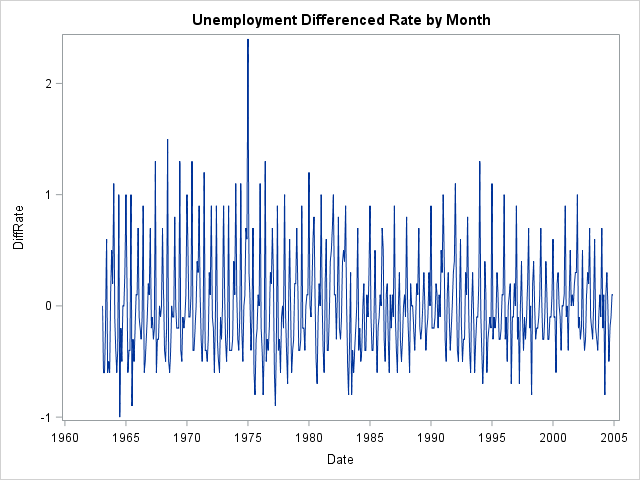

In [37]:
ods graphics on;
title "Unemployment Differenced Rate by Month";
proc sgplot data=DiffUnemployment;
  series x=Date y=DiffRate;
  format date YEAR4.;
run;

### Differenced rate exponential smoothing
Use the same $\lambda$ value of 0.2 as was used for problem 4-23, since that worked
reasonably well.

In [39]:
title "Forecast with Exponential Smoothing On Linear Trend";
proc forecast data=DiffUnemployment
              method=expo
              weight=0.2
              interval=MONTH
              out=DiffUnemploymentForecast outfull outresid outest=est;
  id Date;
  var DiffRate;
run;

### Smoothing of the Differenced Rate
The value of $\lambda$ = 0.2 does not do very much, in fact it almost appears as if some of
the large cycles are more apparent in the smoothed data.


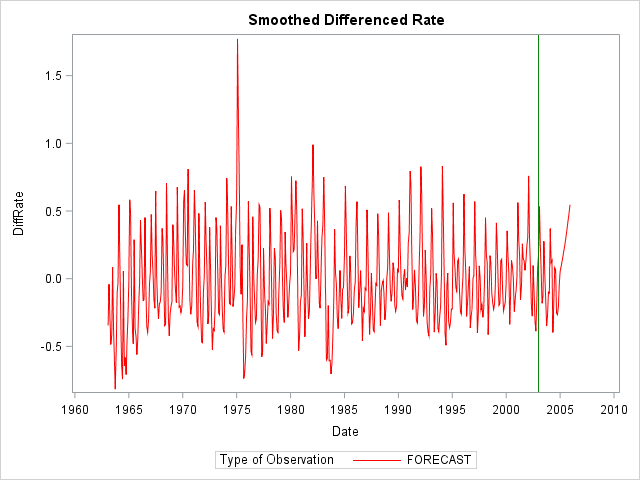

In [41]:
title "Smoothed Differenced Rate";
proc sgplot data=DiffUnemploymentForecast;
  series x=Date y=DiffRate / group =_type_ lineattrs=(color=red);
  where _type_ = 'FORECAST';
  refline '1jan03'd / axis=x lineattrs=(color=green);
  format date YEAR4.;
run;

### CI of differenced rate
This does not perform well.  The LEAD 1 CI is $\pm$ 2%, which given that the data is now rate
differences is not very good.  It goes downhill from there - LEAD 12 is almost $\pm$ 5%.

This is **not** a reasonable model for predicting first differences, especially when you look
at the time-series of the smoothed rate differences, where virtually all of the variations
fall into the $\pm$ 1% range.


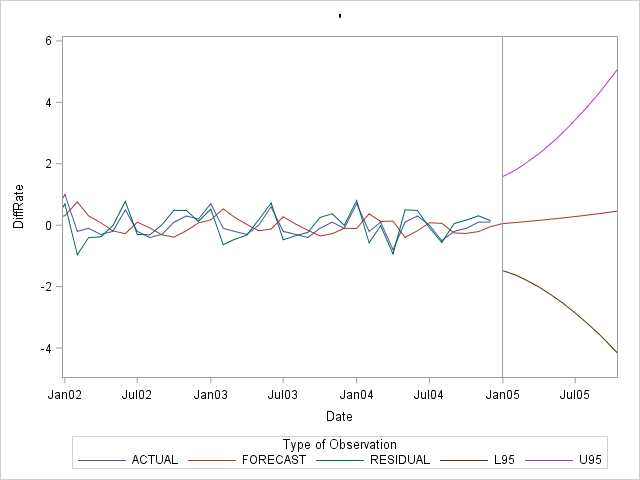

In [42]:
title "";
proc sgplot data=DiffUnemploymentForecast;
  series x=Date y=DIffRate / group=_type_;
  xaxis values=('1jan02'd to '31dec05'd by qtr);
  refline '31dec04'd / axis=x;
  format date monyy5.;
run;